In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import json
import ast
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Compare Incremental

In [69]:
import os
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from src.utils import compute_metrics_for_label

folder_path = "/home/fantoni/patent-sentence-classification/results/incremental"

id2num = {'1': 480, '2': 960, '3': 1440, '4': 1920, '5': 2400, '6': 2880, '7': 3360, '8': 3840, '9': 4320, '10': 4800}

# Compute metrics for bert-for-patents
results = []
for file_name in os.listdir(folder_path):
    if file_name.endswith(".xlsx"):
        
        # Extract sample ID and fold number from filename
        parts = file_name.replace(".xlsx", "").split('_')
        sample_id = parts[1]
        fold_id = parts[2]

        # Load the Excel file into a DataFrame
        df = pd.read_excel(os.path.join(folder_path, file_name))

        # Extract the ground truth and predicted labels
        true_labels = df['sent_tag']
        predicted_labels = df['predicted_tag']

        # Initialize result entry
        result = {
            'Sample Size': id2num[sample_id],
            'Fold': int(fold_id)
        }
        
        # Add per-class precision, recall, and F1-score to the result
        for label in ['All', 'FUN', 'STR', 'MIX', 'OTH']:
            p, r, f1 = compute_metrics_for_label(true_labels, predicted_labels, label=label, average='weighted')
            result[f'Precision_{label}'] = p
            result[f'Recall_{label}'] = r
            result[f'F1-Score_{label}'] = f1

        # Add label counts per training set in the results
        df_train = pd.read_excel(f"/home/fantoni/patent-sentence-classification/data/incremental/train_{sample_id}_{fold_id}.xlsx")
        df_eval = pd.read_excel(f"/home/fantoni/patent-sentence-classification/data/incremental/eval_{sample_id}_{fold_id}.xlsx")
        df = pd.concat([df_train, df_eval], axis=0)
        label_counts = df['sent_tag'].value_counts().to_dict()
        for label, count in label_counts.items():
            result[f"count_{label}"] = count

        results.append(result)

df_results = pd.DataFrame(results).sort_values(by=['Sample Size', 'Fold'])
df_results

,Sample Size,Fold,Precision_All,Recall_All,F1-Score_All,Precision_FUN,Recall_FUN,F1-Score_FUN,Precision_STR,Recall_STR,...,Precision_MIX,Recall_MIX,F1-Score_MIX,Precision_OTH,Recall_OTH,F1-Score_OTH,count_STR,count_FUN,count_MIX,count_OTH
99,480,1,0.524,0.582,0.519,0.549,0.735,0.629,0.608,0.729,...,0.000,0.000,0.000,1.000,0.065,0.122,230,191,36,23
0,480,2,0.539,0.612,0.560,0.564,0.735,0.639,0.636,0.755,...,0.000,0.000,0.000,0.964,0.351,0.514,228,186,33,33
1,480,3,0.553,0.633,0.581,0.585,0.718,0.645,0.655,0.807,...,0.000,0.000,0.000,0.941,0.416,0.577,223,181,41,35
26,480,4,0.518,0.598,0.543,0.550,0.743,0.632,0.635,0.735,...,0.000,0.000,0.000,0.720,0.234,0.353,212,183,46,39
27,480,5,0.537,0.612,0.562,0.562,0.760,0.646,0.646,0.736,...,0.000,0.000,0.000,0.875,0.364,0.514,201,191,50,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,4800,6,0.754,0.757,0.719,0.723,0.854,0.783,0.773,0.910,...,0.700,0.119,0.204,0.906,0.623,0.738,2224,1810,432,334
95,4800,7,0.757,0.762,0.735,0.706,0.898,0.791,0.843,0.836,...,0.653,0.182,0.284,0.670,0.844,0.747,2224,1810,432,334
96,4800,8,0.759,0.765,0.744,0.719,0.893,0.797,0.814,0.865,...,0.625,0.256,0.363,0.894,0.545,0.677,2224,1810,432,334
97,4800,9,0.737,0.753,0.712,0.673,0.920,0.777,0.849,0.841,...,0.542,0.074,0.130,0.747,0.805,0.775,2224,1810,432,334


In [73]:
# Create table with training count
df = df_results.groupby("Sample Size")[['count_FUN', 'count_STR', 'count_MIX', 'count_OTH']].mean().round(3)
df = df.rename(columns={'count_FUN': 'FUN', 'count_STR': 'STR', 'count_MIX': 'MIX', 'count_OTH': 'OTHER'})
df = df.applymap(lambda x: f"{x:,.2f}").T
df = df.reset_index().rename(columns={'index': 'Category'})
df.to_excel('/home/fantoni/patent-sentence-classification/results/tables/incremental_training_count.xlsx', index = False)
df

Sample Size,Category,480,960,1440,1920,2400,2880,3360,3840,4320,4800
0,FUN,184.90,360.80,534.50,712.60,898.20,"1,078.90","1,261.30","1,446.50","1,629.90","1,810.00"
1,STR,221.60,445.50,676.40,902.80,"1,123.20","1,345.10","1,564.60","1,785.20","2,002.60","2,224.00"
2,MIX,41.80,87.10,130.10,172.70,214.90,257.80,299.50,341.20,385.10,432.00
3,OTHER,31.70,66.60,99.00,131.90,163.70,198.20,234.60,267.10,302.40,334.00


In [ ]:
# Create table with mean metrics 
columns = ['Precision_FUN', 'Recall_FUN', 'F1-Score_FUN',
           'Precision_STR', 'Recall_STR', 'F1-Score_STR',
           'Precision_MIX', 'Recall_MIX', 'F1-Score_MIX',
           'Precision_OTH', 'Recall_OTH', 'F1-Score_OTH']

df = df_results.groupby("Sample Size")[columns].mean().round(3).T.reset_index()

df['Metric'] = df['index'].str.extract(r'^(.*)_')[0]
df['Category'] = df['index'].str.extract(r'_(.*)$')[0]

df = df.drop(columns='index')
df = df[['Category', 'Metric'] + list(df.columns[:-2])]

df = df.applymap(lambda x: f"{x:,.3f}" if isinstance(x, (int, float)) else x)

df.to_excel('/home/fantoni/patent-sentence-classification/results/tables/incremental_mean_metrics.xlsx', index = False)
df


Sample Size,Category,Metric,480,960,1440,1920,2400,2880,3360,3840,4320,4800
0,FUN,Precision,0.567,0.632,0.650,0.673,0.676,0.685,0.673,0.682,0.693,0.697
1,FUN,Recall,0.732,0.785,0.832,0.863,0.878,0.886,0.901,0.899,0.900,0.891
2,FUN,F1-Score,0.638,0.700,0.729,0.756,0.763,0.772,0.770,0.775,0.783,0.782
3,STR,Precision,0.638,0.701,0.745,0.779,0.786,0.802,0.813,0.815,0.821,0.816
4,STR,Recall,0.761,0.833,0.842,0.857,0.861,0.852,0.849,0.852,0.850,0.866
5,STR,F1-Score,0.693,0.761,0.789,0.815,0.821,0.826,0.830,0.833,0.834,0.840
6,MIX,Precision,0.057,0.064,0.581,0.402,0.512,0.520,0.441,0.566,0.606,0.610
7,MIX,Recall,0.004,0.003,0.008,0.040,0.036,0.090,0.055,0.077,0.129,0.115
8,MIX,F1-Score,0.008,0.005,0.015,0.067,0.063,0.150,0.094,0.133,0.207,0.186
9,OTH,Precision,0.916,0.834,0.790,0.798,0.798,0.784,0.780,0.773,0.748,0.795


## All

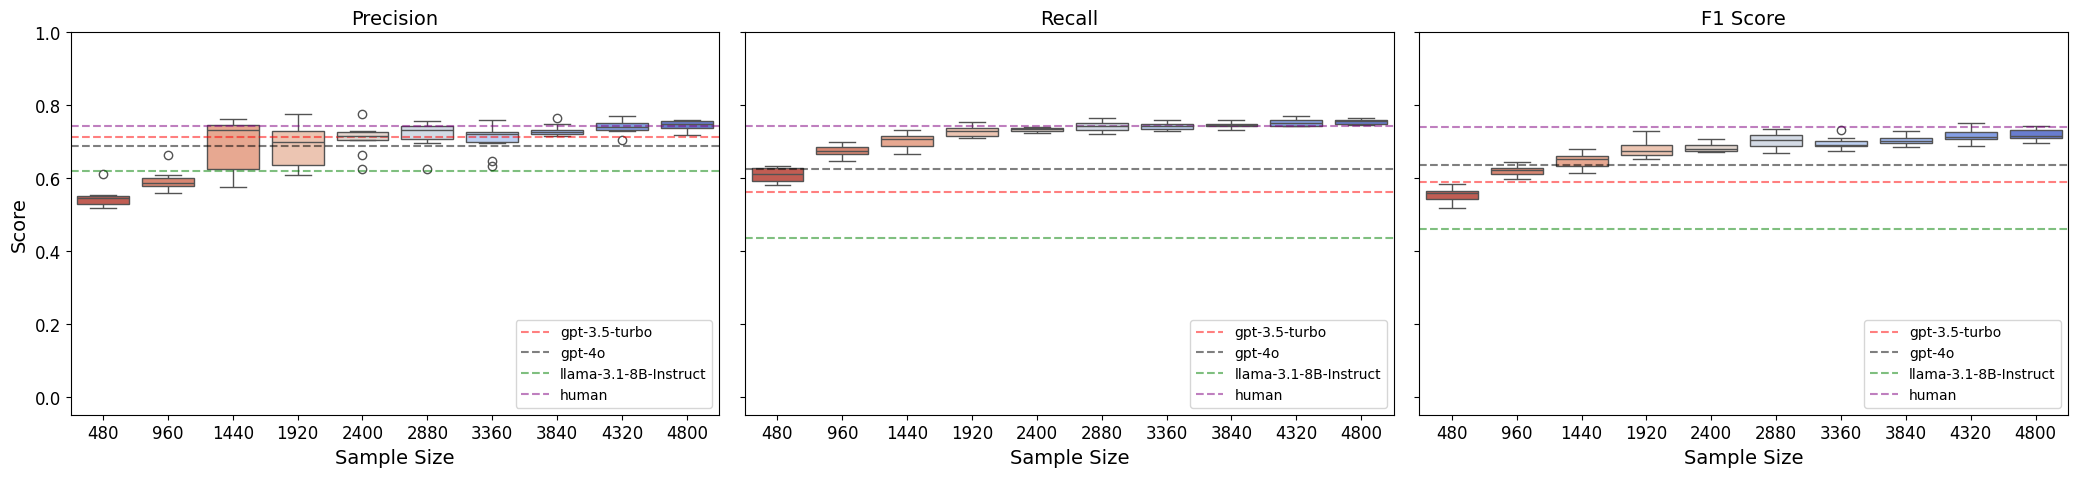

In [70]:
# Import table with all results
df_compare = pd.read_excel('/home/fantoni/patent-sentence-classification/results/tables/comparison_classification.xlsx')

# Set plotting parameters
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 14, 'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 10})

# Create subplots
rows = 1 # All
cols = 3 # Precision, Recall, F1
fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows), sharey=True)

# Define the y-axis limits
y_min = -0.05
y_max = 1

# Get model metrics
# Precision
gpt35_precision = df_compare.query(f"model=='gpt-3.5-turbo'")['precision_All'].iloc[0]
gpt4_precision = df_compare.query(f"model=='gpt-4o'")['precision_All'].iloc[0]
llama_precision = df_compare.query(f"model=='Llama-3.1-8B-Instruct'")['precision_All'].iloc[0]
human_precision = df_compare.query(f"model=='human' ")['precision_All'].iloc[0]

# Recall
gpt35_recall = df_compare.query(f"model=='gpt-3.5-turbo'")['recall_All'].iloc[0]
gpt4_recall = df_compare.query(f"model=='gpt-4o'")['recall_All'].iloc[0]
llama_recall = df_compare.query(f"model=='Llama-3.1-8B-Instruct'")['recall_All'].iloc[0]
human_recall = df_compare.query(f"model=='human' ")['recall_All'].iloc[0]

# F1
gpt35_f1 = df_compare.query(f"model=='gpt-3.5-turbo'")['f1_All'].iloc[0]
gpt4_f1 = df_compare.query(f"model=='gpt-4o'")['f1_All'].iloc[0]
llama_f1 = df_compare.query(f"model=='Llama-3.1-8B-Instruct'")['f1_All'].iloc[0]
human_f1 = df_compare.query(f"model=='human' ")['f1_All'].iloc[0]

# Precision Boxplot
sns.boxplot(x="Sample Size", y="Precision_All", palette="coolwarm_r", data=df_results, ax=axes[0])
axes[0].set_title("Precision")
axes[0].set_ylim(y_min, y_max)
axes[0].set_ylabel("Score")
axes[0].axhline(y=gpt35_precision, color='red', linestyle='--', linewidth=1.5, label=f"gpt-3.5-turbo", alpha=0.5) 
axes[0].axhline(y=gpt4_precision, color='black', linestyle='--', linewidth=1.5, label=f"gpt-4o", alpha=0.5) 
axes[0].axhline(y=llama_precision, color='green', linestyle='--', linewidth=1.5, label=f"llama-3.1-8B-Instruct", alpha=0.5) 
axes[0].axhline(y=human_precision, color='purple', linestyle='--', linewidth=1.5, label=f"human", alpha=0.5) 
axes[0].legend(loc="lower right")

# Recall Boxplot
sns.boxplot(x="Sample Size", y="Recall_All", palette="coolwarm_r", data=df_results, ax=axes[1])
axes[1].set_title("Recall")
axes[1].set_ylim(y_min, y_max)
axes[1].set_ylabel("")
axes[1].axhline(y=gpt35_recall, color='red', linestyle='--', linewidth=1.5, label=f"gpt-3.5-turbo", alpha=0.5) 
axes[1].axhline(y=gpt4_recall, color='black', linestyle='--', linewidth=1.5, label=f"gpt-4o", alpha=0.5) 
axes[1].axhline(y=llama_recall, color='green', linestyle='--', linewidth=1.5, label=f"llama-3.1-8B-Instruct", alpha=0.5)
axes[1].axhline(y=human_recall, color='purple', linestyle='--', linewidth=1.5, label=f"human", alpha=0.5) 
axes[1].legend(loc="lower right")

# F1 Score Boxplot
sns.boxplot(x="Sample Size", y="F1-Score_All", palette="coolwarm_r", data=df_results, ax=axes[2])
axes[2].set_title("F1 Score")
axes[2].set_ylim(y_min, y_max)
axes[2].set_ylabel("")
axes[2].axhline(y=gpt35_f1, color='red', linestyle='--', linewidth=1.5, label=f"gpt-3.5-turbo", alpha=0.5) 
axes[2].axhline(y=gpt4_f1, color='black', linestyle='--', linewidth=1.5, label=f"gpt-4o", alpha=0.5) 
axes[2].axhline(y=llama_f1, color='green', linestyle='--', linewidth=1.5, label=f"llama-3.1-8B-Instruct", alpha=0.5)
axes[2].axhline(y=human_f1, color='purple', linestyle='--', linewidth=1.5, label=f"human", alpha=0.5) 
axes[2].legend(loc="lower right")

plt.tight_layout()
plt.show()

## All, FUN, STR, MIX and OTH

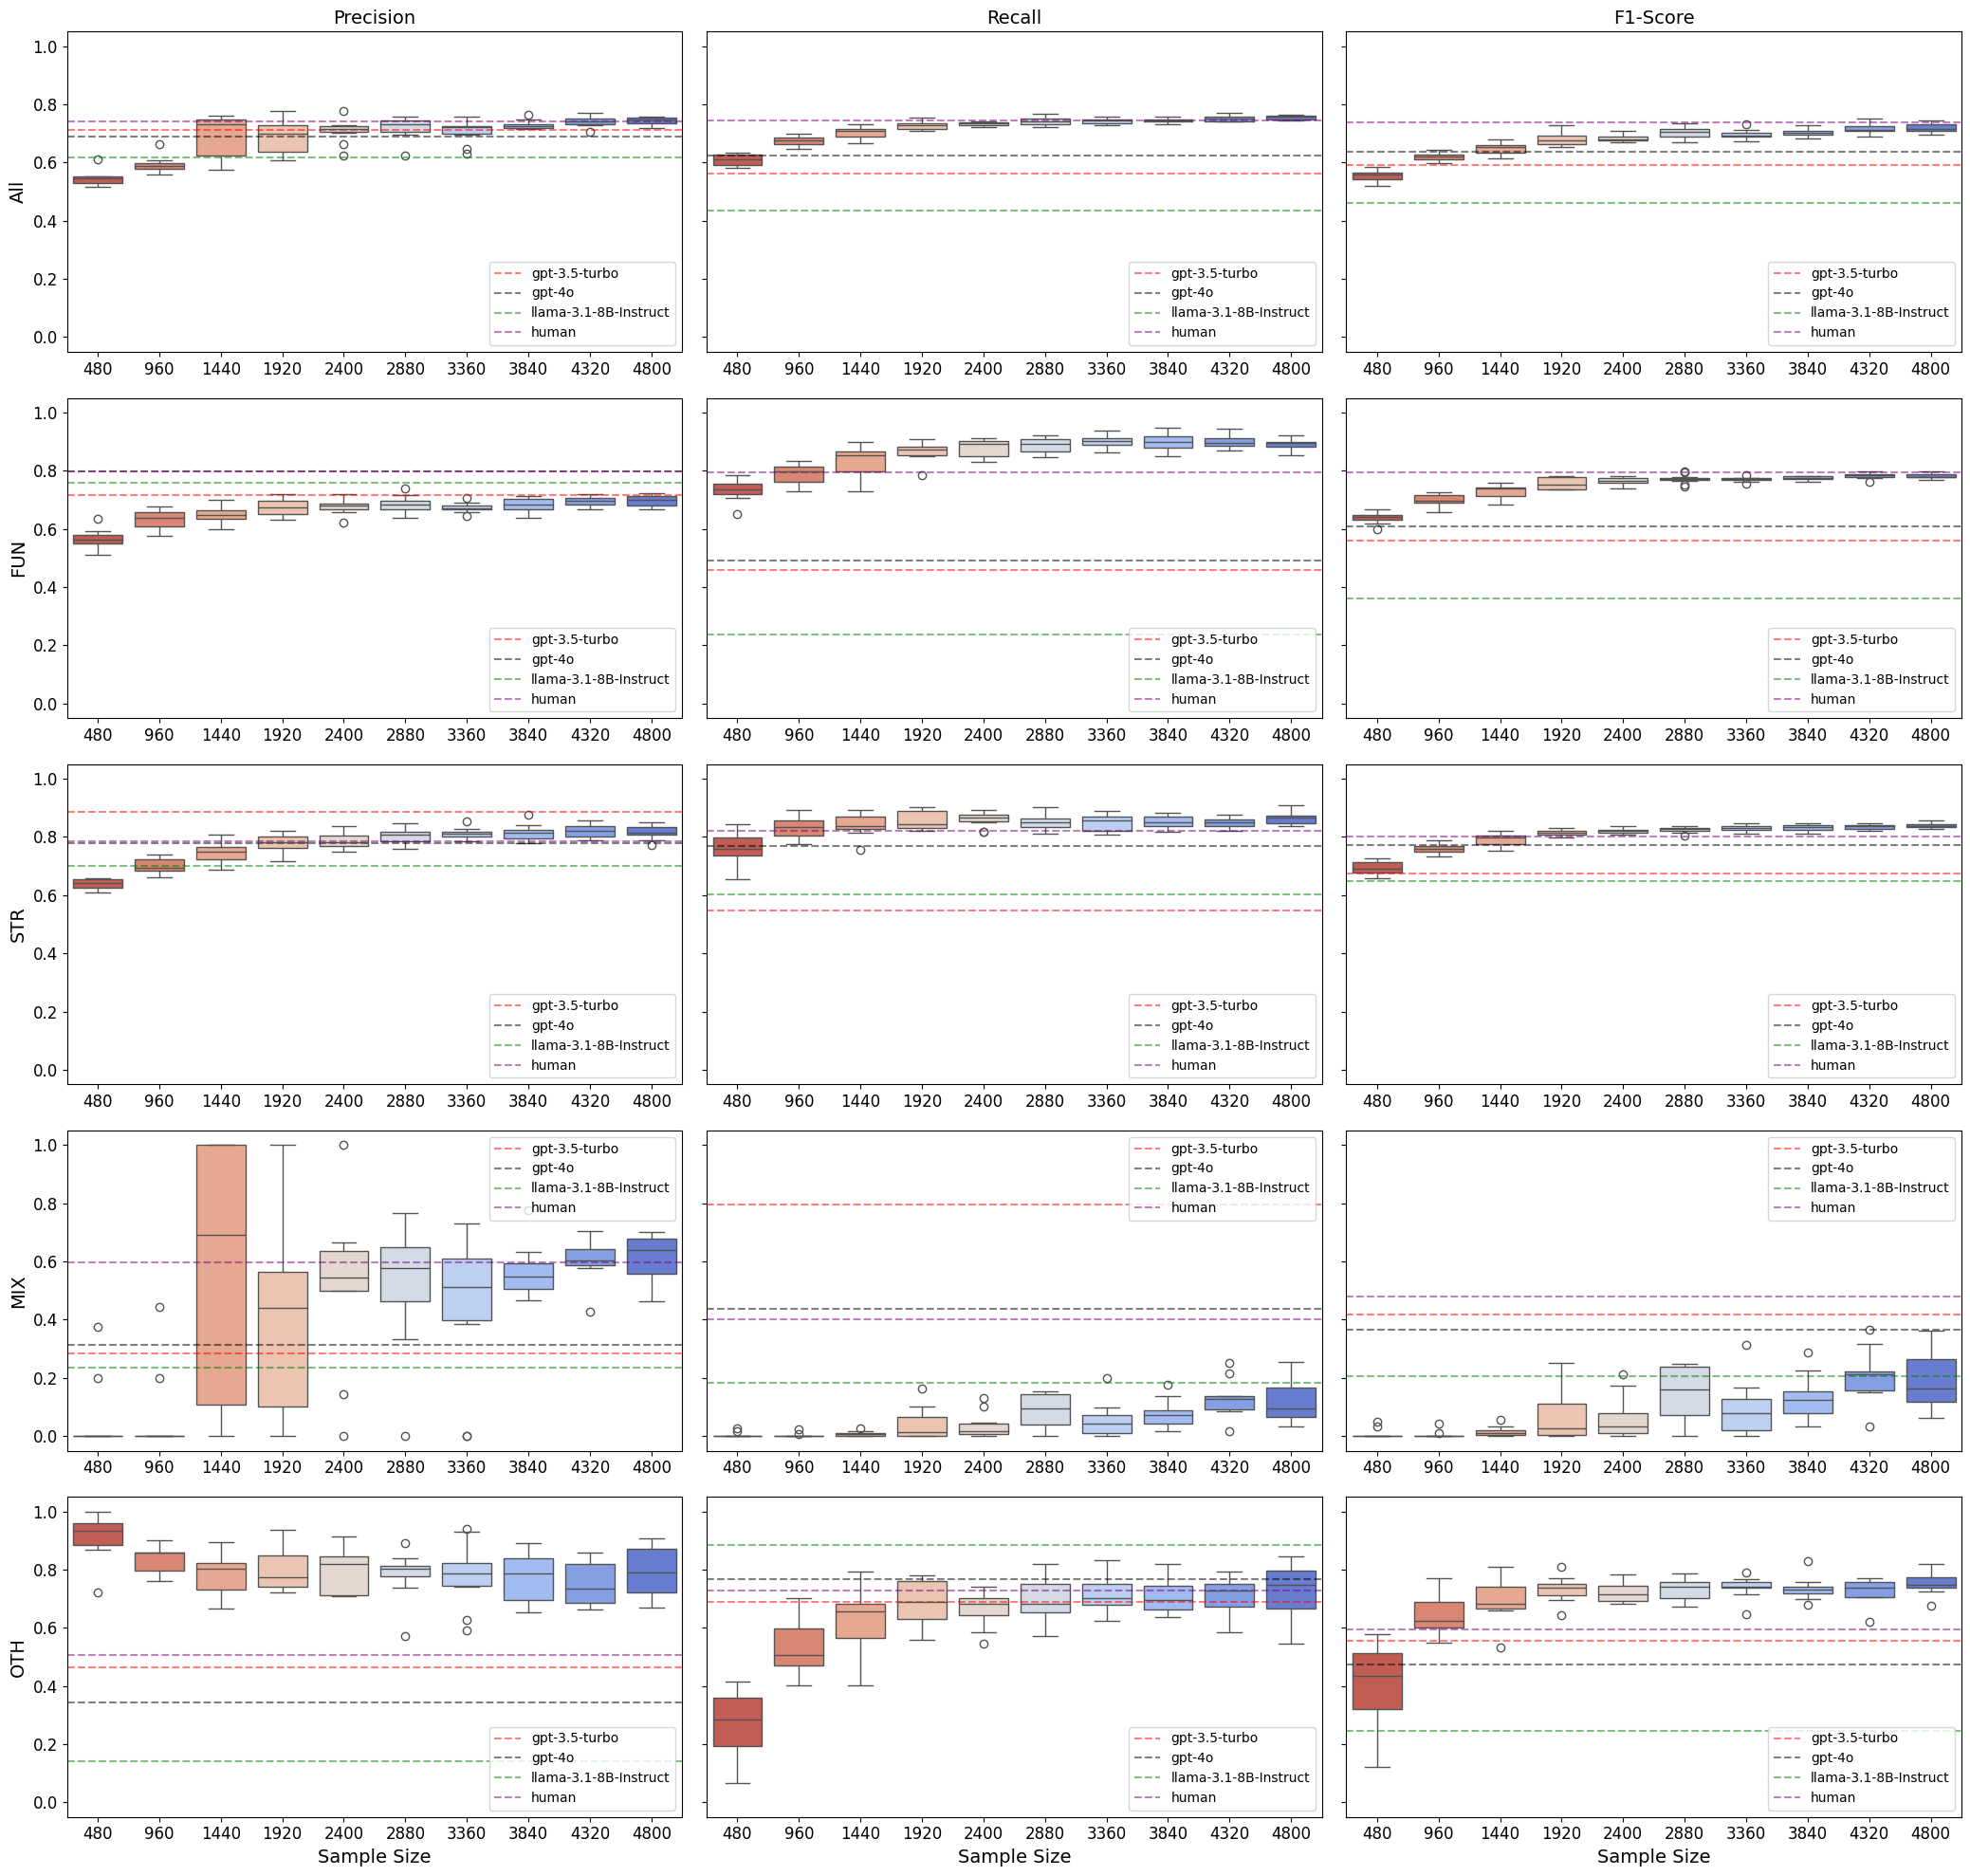

In [71]:
df_compare = pd.read_excel('/home/fantoni/patent-sentence-classification/results/tables/comparison_classification.xlsx')

rows = 5 # All, FUN, STR, MIX, OTH
cols = 3 # Precision, Recall, F1
fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 4 * rows), sharey=True)

y_min = -0.05
y_max = 1.05

for row_idx, mode in enumerate(['All', 'FUN', 'STR', 'MIX', 'OTH']):

    # Get model metrics
    # Precision
    gpt35_precision = df_compare.query(f"model=='gpt-3.5-turbo'")[f'precision_{mode}'].iloc[0]
    gpt4_precision = df_compare.query(f"model=='gpt-4o'")[f'precision_{mode}'].iloc[0]
    llama_precision = df_compare.query(f"model=='Llama-3.1-8B-Instruct'")[f'precision_{mode}'].iloc[0]
    human_precision = df_compare.query(f"model=='human' ")[f'precision_{mode}'].iloc[0]

    # Recall
    gpt35_recall = df_compare.query(f"model=='gpt-3.5-turbo'")[f'recall_{mode}'].iloc[0]
    gpt4_recall = df_compare.query(f"model=='gpt-4o'")[f'recall_{mode}'].iloc[0]
    llama_recall = df_compare.query(f"model=='Llama-3.1-8B-Instruct'")[f'recall_{mode}'].iloc[0]
    human_recall = df_compare.query(f"model=='human' ")[f'recall_{mode}'].iloc[0]

    # F1
    gpt35_f1 = df_compare.query(f"model=='gpt-3.5-turbo'")[f'f1_{mode}'].iloc[0]
    gpt4_f1 = df_compare.query(f"model=='gpt-4o'")[f'f1_{mode}'].iloc[0]
    llama_f1 = df_compare.query(f"model=='Llama-3.1-8B-Instruct'")[f'f1_{mode}'].iloc[0]
    human_f1 = df_compare.query(f"model=='human' ")[f'f1_{mode}'].iloc[0]
    
    # Precision
    sns.boxplot(x="Sample Size", y=f"Precision_{mode}", palette="coolwarm_r", data=df_results, ax=axes[row_idx, 0])
    axes[row_idx, 0].set_title('Precision') if row_idx == 0 else axes[row_idx, 0].set_title('')
    axes[row_idx, 0].set_xlabel('Sample Size') if row_idx == 4 else axes[row_idx, 0].set_xlabel('') 
    axes[row_idx, 0].set_ylim(y_min, y_max)
    axes[row_idx, 0].set_ylabel(mode)
    axes[row_idx, 0].axhline(y=gpt35_precision, color='red', linestyle='--', linewidth=1.5, label="gpt-3.5-turbo", alpha=0.5) 
    axes[row_idx, 0].axhline(y=gpt4_precision, color='black', linestyle='--', linewidth=1.5, label="gpt-4o", alpha=0.5) 
    axes[row_idx, 0].axhline(y=llama_precision, color='green', linestyle='--', linewidth=1.5, label="llama-3.1-8B-Instruct", alpha=0.5) 
    axes[row_idx, 0].axhline(y=human_precision, color='purple', linestyle='--', linewidth=1.5, label="human", alpha=0.5) 
    axes[row_idx, 0].legend(loc="lower right") if mode != 'MIX' else axes[row_idx, 0].legend(loc="upper right")

    # Recall
    sns.boxplot(x="Sample Size", y=f"Recall_{mode}", palette="coolwarm_r", data=df_results, ax=axes[row_idx, 1])
    axes[row_idx, 1].set_title('Recall') if row_idx == 0 else axes[row_idx, 1].set_title('')
    axes[row_idx, 1].set_xlabel('Sample Size') if row_idx == 4 else axes[row_idx, 1].set_xlabel('') 
    axes[row_idx, 1].set_ylim(y_min, y_max)
    axes[row_idx, 1].set_ylabel('')
    axes[row_idx, 1].axhline(y=gpt35_recall, color='red', linestyle='--', linewidth=1.5, label="gpt-3.5-turbo", alpha=0.5) 
    axes[row_idx, 1].axhline(y=gpt4_recall, color='black', linestyle='--', linewidth=1.5, label="gpt-4o", alpha=0.5) 
    axes[row_idx, 1].axhline(y=llama_recall, color='green', linestyle='--', linewidth=1.5, label="llama-3.1-8B-Instruct", alpha=0.5)
    axes[row_idx, 1].axhline(y=human_recall, color='purple', linestyle='--', linewidth=1.5, label="human", alpha=0.5) 
    axes[row_idx, 1].legend(loc="lower right") if mode != 'MIX' else axes[row_idx, 1].legend(loc="upper right")

    # F1-Score
    sns.boxplot(x="Sample Size", y=f'F1-Score_{mode}', palette="coolwarm_r", data=df_results, ax=axes[row_idx, 2])
    axes[row_idx, 2].set_title('F1-Score') if row_idx == 0 else axes[row_idx, 2].set_title('')
    axes[row_idx, 2].set_xlabel('Sample Size') if row_idx == 4 else axes[row_idx, 2].set_xlabel('') 
    axes[row_idx, 2].set_ylim(y_min, y_max)
    axes[row_idx, 2].set_ylabel('')
    axes[row_idx, 2].axhline(y=gpt35_f1, color='red', linestyle='--', linewidth=1.5, label="gpt-3.5-turbo", alpha=0.5) 
    axes[row_idx, 2].axhline(y=gpt4_f1, color='black', linestyle='--', linewidth=1.5, label="gpt-4o", alpha=0.5) 
    axes[row_idx, 2].axhline(y=llama_f1, color='green', linestyle='--', linewidth=1.5, label="llama-3.1-8B-Instruct", alpha=0.5)
    axes[row_idx, 2].axhline(y=human_f1, color='purple', linestyle='--', linewidth=1.5, label="human", alpha=0.5) 
    axes[row_idx, 2].legend(loc="lower right") if mode != 'MIX' else axes[row_idx, 2].legend(loc="upper right")

plt.tight_layout()
plt.show()

# Compare on Agreement - WIP

In [ ]:
import os
import pandas as pd
import ast

folder_path = "/home/fantoni/patent-sentence-classification/results/incremental"
id2num = {'1': 480, '2': 960, '3': 1440, '4': 1920, '5': 2400, '6': 2880, '7': 3360, '8': 3840, '9': 4320, '10': 4800}

# Import agreement data
agreement_df = pd.read_excel("/home/fantoni/patent-sentence-classification/data/1200_agreement_All.xlsx", usecols=['sent_id', 'agreement'])

# Process all files
results_all = []
for file_name in os.listdir(folder_path):
    if file_name.endswith(".xlsx"):
        sample_id = file_name.split('_')[1]
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)

        # Merge with agreement data
        df = pd.merge(df, agreement_df, on='sent_id', how='left')

        # Compute correct predictions
        df['correct'] = df['sent_class'] == df['predicted_class']
        
        # Extract max probabilities
        df["probabilities"] = df["probabilities"].apply(ast.literal_eval) # import as a list
        df['max_prob'] = df['probabilities'].apply(max)
        
        # Collect data 
        data = {
            'Sample Size': id2num[sample_id],
            'max_prob': df['max_prob'].tolist(),
            'agreement': df['agreement'].tolist(),
            'correct': df['correct'].tolist()
        }

        results_all.append(data)

# Convert and explode DataFrame
df_results = pd.DataFrame(results_all).sort_values(by='Sample Size')
df_results = df_results.explode(['max_prob', 'agreement', 'correct']).reset_index(drop=True)
df_results

,Sample Size,max_prob,agreement,correct
0,480,0.5,False,False
1,480,0.61,True,True
2,480,0.49,False,True
3,480,0.53,True,True
4,480,0.38,True,True
...,...,...,...,...
119995,4800,0.65,False,False
119996,4800,0.73,True,True
119997,4800,0.94,True,True
119998,4800,0.88,False,True


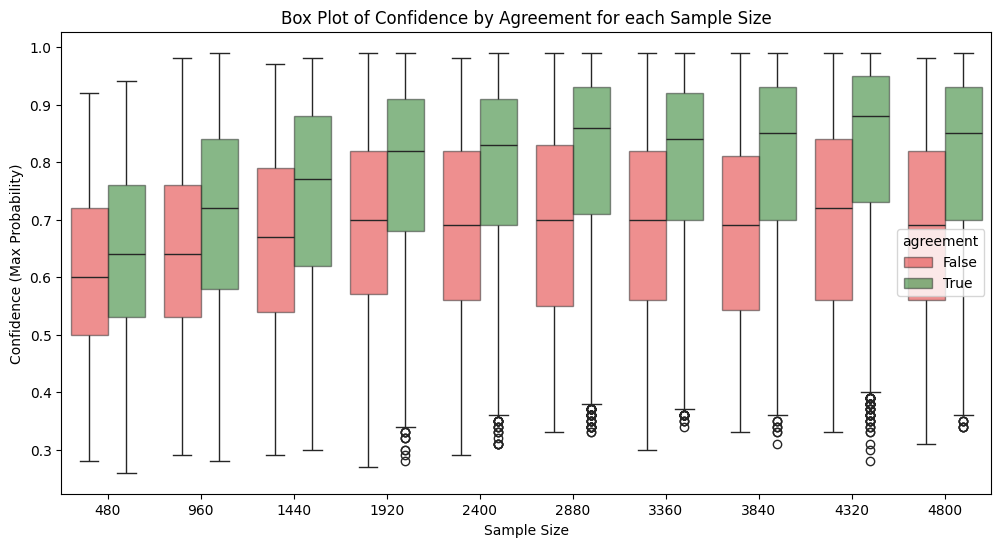

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot for 'max_prob' by 'agreement', grouped by 'Sample Size'
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_results,
    x='Sample Size',
    y='max_prob',
    hue='agreement',
    palette={True: 'green', False: 'red'},
    boxprops=dict(alpha=0.5))
    
plt.xlabel("Sample Size")
plt.ylabel("Confidence (Max Probability)")
plt.title("Box Plot of Confidence by Agreement for each Sample Size")
plt.show()

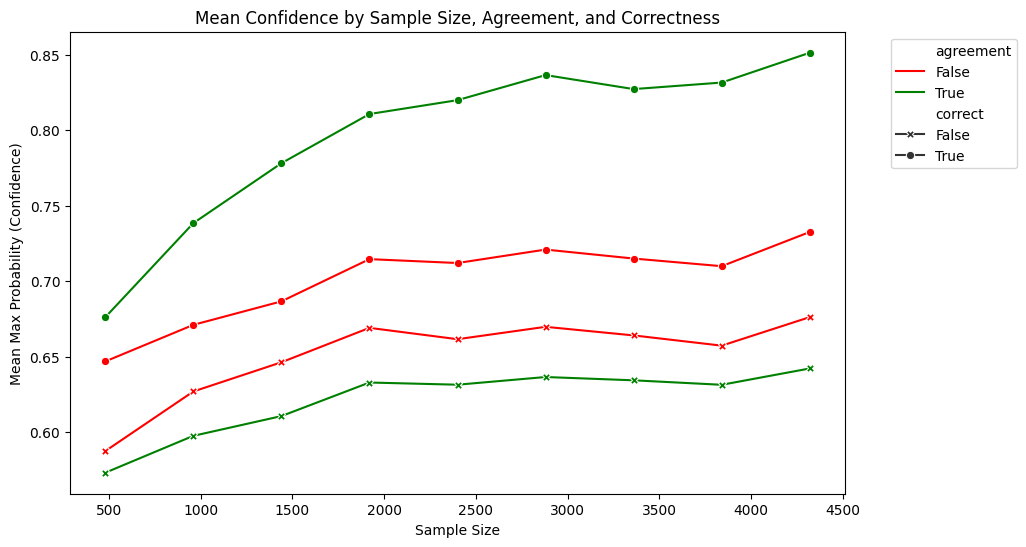

In [86]:
# Compute mean max_prob grouped by 'Sample Size' and 'Agreement' and 'Correct'
mean_df = exploded_df.groupby(['Sample Size', 'agreement', 'correct'])['max_prob'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=mean_df,
    x="Sample Size",
    y="max_prob",
    hue="agreement",
    style="correct",
    markers={True: "o", False: "X"},  # Marker style for 'correct'
    dashes=False,  # Use solid lines
    palette={True: "green", False: "red"}  # Color mapping
)

plt.xlabel("Sample Size")
plt.ylabel("Mean Max Probability (Confidence)")
plt.title("Mean Confidence by Sample Size, Agreement, and Correctness")
plt.legend(title="", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()